Setup the environment to use TensorFlow, Keras, and Dataset (GOPRO,Berkely segmentation dataset 500 (BSD500)) manipulation

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import tensorflow as tf
from tensorflow.keras import layers, models

# For motion blur
import cv2

# For data loading & augmentation
import tensorflow_datasets as tfds


In [11]:
from tensorflow.image import psnr, ssim

def evaluate_psnr_ssim(model, dataset, max_val=1.0):
    psnr_vals = []
    ssim_vals = []

    for noisy, clean in dataset:
        denoised = model.predict(noisy, verbose=0)
        for i in range(denoised.shape[0]):
            psnr_val = psnr(clean[i], denoised[i], max_val=max_val).numpy()
            ssim_val = ssim(clean[i], denoised[i], max_val=max_val).numpy()
            psnr_vals.append(psnr_val)
            ssim_vals.append(ssim_val)

    mean_psnr = sum(psnr_vals) / len(psnr_vals)
    mean_ssim = sum(ssim_vals) / len(ssim_vals)
    return mean_psnr, mean_ssim


In [12]:
import os
import numpy as np
from PIL import Image

def load_gopro_dataset(blur_dir, sharp_dir, image_size=(256, 256), limit=None):
    X_blur = []
    Y_sharp = []

    blur_images = sorted(os.listdir(blur_dir))[:limit]
    for img_name in blur_images:
        blur_path = os.path.join(blur_dir, img_name)
        sharp_path = os.path.join(sharp_dir, img_name)  # same filename assumed

        # Load and preprocess
        blur_img = Image.open(blur_path).convert('L').resize(image_size)
        sharp_img = Image.open(sharp_path).convert('L').resize(image_size)

        # Normalize and expand dims to (H, W, 1)
        blur_np = np.expand_dims(np.array(blur_img).astype('float32') / 255., axis=-1)
        sharp_np = np.expand_dims(np.array(sharp_img).astype('float32') / 255., axis=-1)


        # Ensure 3 channels
        if blur_np.ndim == 2:
            blur_np = np.expand_dims(blur_np, -1)
        if sharp_np.ndim == 2:
            sharp_np = np.expand_dims(sharp_np, -1)

        X_blur.append(blur_np)
        Y_sharp.append(sharp_np)

    return np.array(X_blur), np.array(Y_sharp)


In [13]:
def load_gopro_dataset_all(data_dir, image_size=(256, 256), limit_per_sequence=None):
    def load_split(split):
        X_total, Y_total = [], []
        split_path = os.path.join(data_dir, split)
        sequences = sorted(os.listdir(split_path))

        for seq in sequences:
            blur_dir = os.path.join(split_path, seq, "blur")
            sharp_dir = os.path.join(split_path, seq, "sharp")

            if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
                print(f"Loading {split}/{seq}...")
                X_blur, Y_sharp = load_gopro_dataset(
                    blur_dir, sharp_dir,
                    image_size=image_size,
                    limit=limit_per_sequence
                )
                X_total.extend(X_blur)
                Y_total.extend(Y_sharp)

        return np.array(X_total), np.array(Y_total)

    X_train, Y_train = load_split("train")
    X_test, Y_test = load_split("test")
    return (X_train, Y_train), (X_test, Y_test)


In [14]:
def add_gaussian_noise(img_array, mean=0.0, std=0.05):
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = img_array + noise
    return np.clip(noisy_img, 0., 1.)

In [15]:
def process_bsd500_gaussian_blur_noise(image_dir, image_size=(256, 256), limit=None, blur_radius=2.5, noise_std=0.05):
    X_clean = []
    X_noisy = []

    image_files = sorted(os.listdir(image_dir))[:limit]

    for fname in image_files:
        path = os.path.join(image_dir, fname)
        try:
            img = Image.open(path).convert('L').resize(image_size)

            # Original clean image
            clean_np = np.array(img).astype('float32') / 255.
            clean_np = np.expand_dims(clean_np, axis=-1)  # Add channel dim (H, W, 1)

            # Apply Gaussian blur
            blurred_img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
            blurred_np = np.array(blurred_img).astype('float32') / 255.
            blurred_np = np.expand_dims(blurred_np, axis=-1)  # Add channel dim (H, W, 1)

            # Add Gaussian noise
            noisy_np = add_gaussian_noise(blurred_np, std=noise_std)

            X_clean.append(clean_np)
            X_noisy.append(noisy_np)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return np.array(X_noisy), np.array(X_clean)



In [16]:
import tensorflow as tf

def create_tf_dataset(X_input, X_target, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X_input, X_target))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_input))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [17]:
from tensorflow.keras import layers, Model

def build_autoencoder_v2(input_shape=(256, 256, 1)):
    input_layer = layers.Input(shape=input_shape, name="NoisedImage")

    # Encoder
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(input_layer)  # 128x128
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)            # 64x64
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)           # 32x32

    # Latent space
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(x)

    # Decoder
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 64x64
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 128x128
    x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 256x256

    # Output
    output_layer = layers.Conv2D(1, kernel_size=1, strides=1, padding="same", activation='sigmoid', name="DenoisedImage")(x)

    return Model(inputs=input_layer, outputs=output_layer, name="AutoEncoderV2")


In [18]:
"""from tensorflow.keras import layers, Model

def build_autoencoder_v2(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # 128x128

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # 64x64

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # 32x32

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)  # 16x16

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(bn)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(c8)

    return Model(inputs, outputs, name="DeepUNetAutoencoder")
"""

'from tensorflow.keras import layers, Model\n\ndef build_autoencoder_v2(input_shape=(256, 256, 1)):\n    inputs = layers.Input(shape=input_shape)\n\n    # Encoder\n    c1 = layers.Conv2D(64, 3, activation=\'relu\', padding=\'same\')(inputs)\n    c1 = layers.Conv2D(64, 3, activation=\'relu\', padding=\'same\')(c1)\n    p1 = layers.MaxPooling2D((2, 2))(c1)  # 128x128\n\n    c2 = layers.Conv2D(128, 3, activation=\'relu\', padding=\'same\')(p1)\n    c2 = layers.Conv2D(128, 3, activation=\'relu\', padding=\'same\')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)  # 64x64\n\n    c3 = layers.Conv2D(256, 3, activation=\'relu\', padding=\'same\')(p2)\n    c3 = layers.Conv2D(256, 3, activation=\'relu\', padding=\'same\')(c3)\n    p3 = layers.MaxPooling2D((2, 2))(c3)  # 32x32\n\n    c4 = layers.Conv2D(512, 3, activation=\'relu\', padding=\'same\')(p3)\n    c4 = layers.Conv2D(512, 3, activation=\'relu\', padding=\'same\')(c4)\n    p4 = layers.MaxPooling2D((2, 2))(c4)  # 16x16\n\n    # Bottleneck\n  

In [19]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:", gpus[0])
else:
    print("No GPU detected — training may be slow.")


GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1745696671.100720    2287 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745696671.684366    2287 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745696671.688355    2287 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [20]:
if __name__ == '__main__':
    # Load the dataset
    # Make sure to set the correct path to your dataset
    # The dataset should be structured as:
    # GoPro/
    # ├── train/
    # │   ├── sequence_1/
    # │   │   ├── blur/
    # |   |   ├── blur_gamma
    # │   │   └── sharp/
    # │   └── sequence_2/
    # │       ├── blur/
    # |       ├── blur_gamma
    # │       └── sharp/
    # └── test/
    #     ├── sequence_1/
    #     │   ├── blur/
    #     |   ├── blur_gamma
    #     │   └── sharp/
    #     └── sequence_2/
    #         ├── blur/
    #         ├── blur_gamma
    #         └── sharp/


    # BSDS500/ 
    #       ├── images/
    #       │   │   ├── train/
    #       │   │   ├── test/
    #       │   │   └── val/
    #       │   └── groundTruth/
    #       │       ├── train/
    #       │       ├── test/
    #       │       └── val/


    # === GoPro Dataset ===
    data_path = "../../../GOPRO"  # adjust as needed
    (X_train_gopro, Y_train_gopro), (X_test_gopro, Y_test_gopro) = load_gopro_dataset_all(
        data_dir=data_path,
        image_size=(256, 256),
        limit_per_sequence=200
    )
    print("GoPro train:", X_train_gopro.shape, Y_train_gopro.shape)
    print("GoPro test:", X_test_gopro.shape, Y_test_gopro.shape)

    test_dataset_gopro = create_tf_dataset(X_test_gopro, Y_test_gopro, batch_size=16, shuffle=False)

    from sklearn.model_selection import train_test_split

    # Split 10% of training into validation set
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train_gopro, Y_train_gopro, test_size=0.1, random_state=42
    )

    # === BSD500 Dataset ===
    bsd_path = "../../../BSD500/images/train"  # update this to your extracted BSD path

    X_bsd_blur, X_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_path,
        image_size=(256, 256),
        limit=200,
        blur_radius=2.5,
        noise_std=0.05
    )
    print("BSD500 processed:", X_bsd_blur.shape, X_bsd_clean.shape)

    # === Convert BSD to tf.data.Dataset ===
    bsd_dataset = create_tf_dataset(X_bsd_blur, X_bsd_clean, batch_size=16)

    #show a batch
    for noisy, clean in bsd_dataset.take(1):
        print("Batch sample shapes:", noisy.shape, clean.shape)
    

    # Combine BSD500 + GoPro training data
    X_combined = np.concatenate([X_bsd_blur, X_train], axis=0)
    Y_combined = np.concatenate([X_bsd_clean, Y_train], axis=0)

    print("Combined training dataset shape:", X_combined.shape)
    print("→ From BSD500:", X_bsd_blur.shape[0])
    print("→ From GoPro:", X_train.shape[0])


    # === BSD500 Validation ===
    bsd_val_path = "../../../BSD500/images/val"
    X_val_bsd_blur, X_val_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_val_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    val_dataset_bsd = create_tf_dataset(X_val_bsd_blur, X_val_bsd_clean, batch_size=16, shuffle=False)

    bsd_test_path = "../../../BSD500/images/test"
    X_test_bsd_blur, X_test_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_test_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    test_dataset_bsd = create_tf_dataset(X_test_bsd_blur, X_test_bsd_clean, batch_size=16, shuffle=False)

    train_dataset = create_tf_dataset(X_combined, Y_combined, batch_size=16)
    val_dataset   = create_tf_dataset(X_val, Y_val, batch_size=16, shuffle=False)



Loading train/GOPR0372_07_00...
Loading train/GOPR0372_07_01...
Loading train/GOPR0374_11_00...
Loading train/GOPR0374_11_01...
Loading train/GOPR0374_11_02...
Loading train/GOPR0374_11_03...
Loading train/GOPR0378_13_00...
Loading train/GOPR0379_11_00...
Loading train/GOPR0380_11_00...
Loading train/GOPR0384_11_01...
Loading train/GOPR0384_11_02...
Loading train/GOPR0384_11_03...
Loading train/GOPR0384_11_04...
Loading train/GOPR0385_11_00...
Loading train/GOPR0386_11_00...
Loading train/GOPR0477_11_00...
Loading train/GOPR0857_11_00...
Loading train/GOPR0868_11_01...
Loading train/GOPR0868_11_02...
Loading train/GOPR0871_11_01...
Loading train/GOPR0881_11_00...
Loading train/GOPR0884_11_00...
Loading test/GOPR0384_11_00...
Loading test/GOPR0384_11_05...
Loading test/GOPR0385_11_01...
Loading test/GOPR0396_11_00...
Loading test/GOPR0410_11_00...
Loading test/GOPR0854_11_00...
Loading test/GOPR0862_11_00...
Loading test/GOPR0868_11_00...
Loading test/GOPR0869_11_00...
Loading test/GOPR

I0000 00:00:1745696875.761227    2287 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745696875.765162    2287 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745696875.768508    2287 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745696875.945995    2287 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

BSD500 processed: (200, 256, 256, 1) (200, 256, 256, 1)
Batch sample shapes: (16, 256, 256, 1) (16, 256, 256, 1)


2025-04-26 19:47:59.156433: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Combined training dataset shape: (2092, 256, 256, 1)
→ From BSD500: 200
→ From GoPro: 1892
Error processing ../../../BSD500/images/val/Thumbs.db: cannot identify image file '../../../BSD500/images/val/Thumbs.db'
Error processing ../../../BSD500/images/test/Thumbs.db: cannot identify image file '../../../BSD500/images/test/Thumbs.db'


2025-04-26 19:48:03.264710: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1096810496 exceeds 10% of free system memory.
2025-04-26 19:48:04.151614: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 548405248 exceeds 10% of free system memory.
2025-04-26 19:48:04.550810: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1096810496 exceeds 10% of free system memory.
2025-04-26 19:48:05.182593: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 548405248 exceeds 10% of free system memory.


In [21]:
# === Build and compile model ===
autoencoder = build_autoencoder_v2(input_shape=(256, 256, 1))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

train_losses = []
val_losses_gopro = []
val_losses_bsd = []

EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # 1. Train for 1 epoch
    history = autoencoder.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1)

    # 2. Save training + GoPro val loss
    train_losses.append(history.history['loss'][0])
    val_losses_gopro.append(history.history['val_loss'][0])

    # 3. Evaluate on BSD500 val set
    val_loss_bsd = autoencoder.evaluate(val_dataset_bsd, verbose=0)
    val_losses_bsd.append(val_loss_bsd)



Epoch 1/20


2025-04-26 19:48:06.954688: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1096810496 exceeds 10% of free system memory.
I0000 00:00:1745696889.626730    2355 service.cc:146] XLA service 0x76a6140465d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745696889.626763    2355 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2025-04-26 19:48:09.724938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-26 19:48:10.083013: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 15/131 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6920

I0000 00:00:1745696894.889193    2355 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.6390 - val_loss: 0.5829

Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5769 - val_loss: 0.5779

Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5717 - val_loss: 0.5767

Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5710 - val_loss: 0.5761

Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5733 - val_loss: 0.5772

Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5723 - val_loss: 0.5752

Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5712 - val_loss: 0.5749

Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5704 - val_loss: 0.5744

Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5692 - val_loss: 0.5748

Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5711 - val_loss: 0.5742

Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5703 - val_loss: 0.5741

Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━

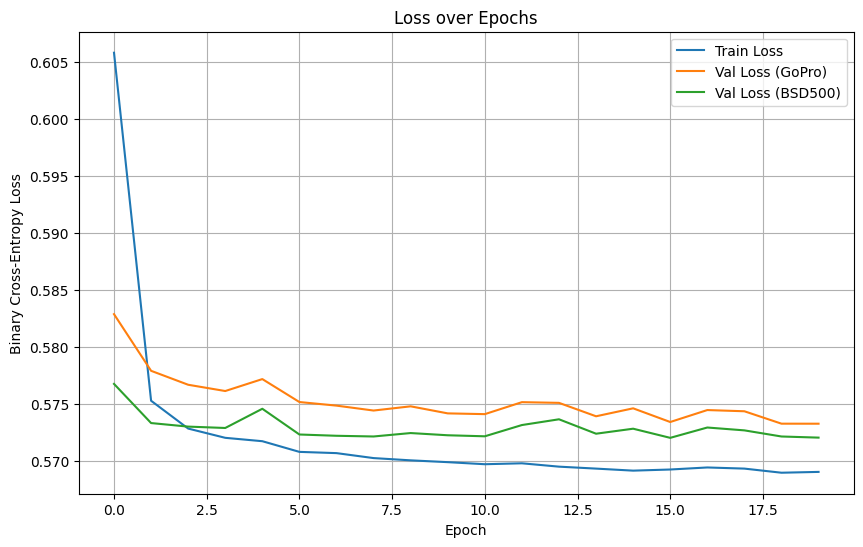

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses_gopro, label="Val Loss (GoPro)")
plt.plot(val_losses_bsd, label="Val Loss (BSD500)")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()



In [23]:
# === Evaluate PSNR and SSIM on test datasets ===
psnr_gopro, ssim_gopro = evaluate_psnr_ssim(autoencoder, test_dataset_gopro)
psnr_bsd, ssim_bsd = evaluate_psnr_ssim(autoencoder, test_dataset_bsd)

print(f"📷 PSNR (GoPro): {psnr_gopro:.2f}, SSIM (GoPro): {ssim_gopro:.4f}")
print(f"📷 PSNR (BSD500): {psnr_bsd:.2f}, SSIM (BSD500): {ssim_bsd:.4f}")



# === Evaluate on test sets ===
print("Test on GoPro:")
autoencoder.evaluate(test_dataset_gopro)

print("Test on BSD500:")
autoencoder.evaluate(test_dataset_bsd)


W0000 00:00:1745696936.586779    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.601446    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.602032    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.602472    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.604783    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.616142    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.618177    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.618616    2287 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745696936.619082    2287 gp

📷 PSNR (GoPro): 25.83, SSIM (GoPro): 0.8084
📷 PSNR (BSD500): 23.01, SSIM (BSD500): 0.5117
Test on GoPro:
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5811
Test on BSD500:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5858


0.5754469037055969

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


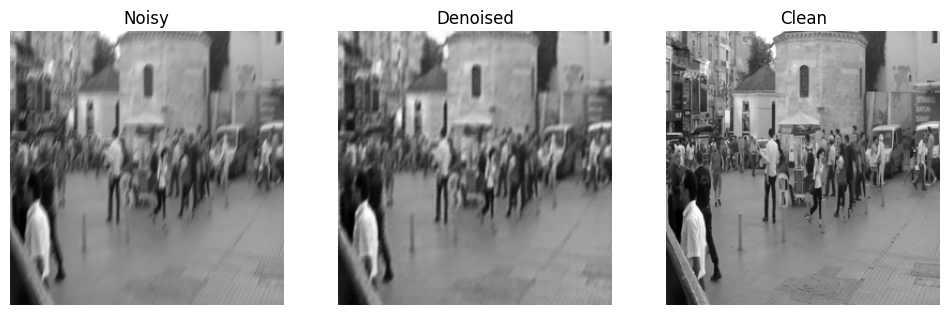

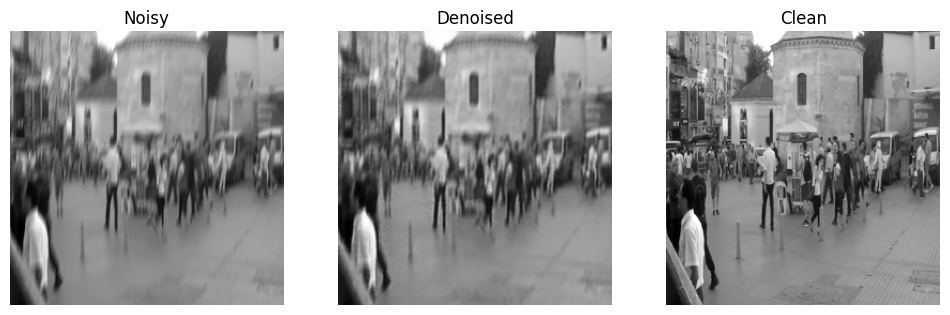

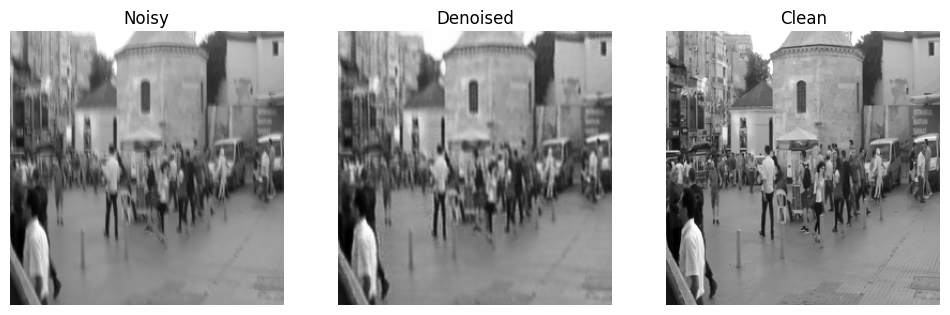

2025-04-26 19:49:26.990576: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


: 

In [ ]:
# === Visualize a few test results ===
import matplotlib.pyplot as plt

for noisy, clean in test_dataset_gopro.take(1):
    pred = autoencoder.predict(noisy)

    for i in range(3):  # show 3 examples
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Noisy")
        plt.imshow(noisy[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Denoised")
        plt.imshow(pred[i].squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Clean")
        plt.imshow(clean[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")
        plt.show()
